<a href="https://colab.research.google.com/github/AmarjitMahadik007/Syntactic-Processing/blob/master/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [2]:
!pip install pycrf
!pip install sklearn-crfsuite

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1870 sha256=7087a8762bbd74d6f269b286911879c22e07159166eabdb8076d3b6dc59f2a05
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00


In [3]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

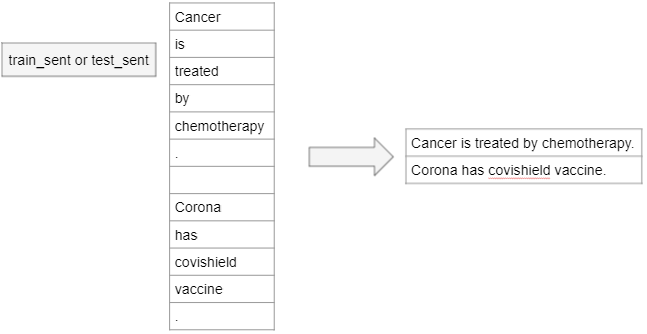

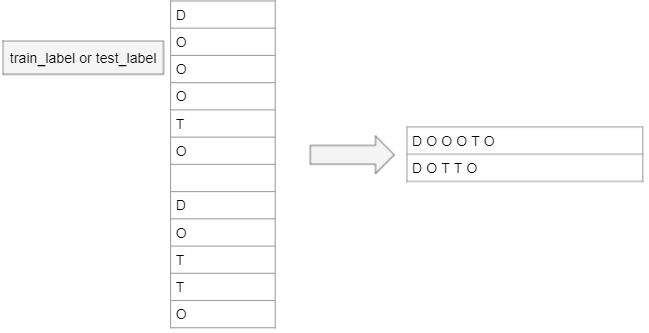

In [4]:
with open('train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()


In [5]:
# Print the 6th sentence in the test set i.e. index value 5.
print(train_sentences[0:48])

# Print the labels of this sentence
print(train_labels[0:48])

['All\n', 'live\n', 'births\n', '>\n', 'or\n', '=\n', '23\n', 'weeks\n', 'at\n', 'the\n', 'University\n', 'of\n', 'Vermont\n', 'in\n', '1995\n', '(\n', 'n\n', '=\n', '2395\n', ')\n', 'were\n', 'retrospectively\n', 'analyzed\n', 'for\n', 'delivery\n', 'route\n', ',\n', 'indication\n', 'for\n', 'cesarean\n', ',\n', 'gestational\n', 'age\n', ',\n', 'parity\n', ',\n', 'and\n', 'practice\n', 'group\n', '(\n', 'to\n', 'reflect\n', 'risk\n', 'status\n', ')\n', '\n', 'The\n', 'total\n']
['O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', 'O\n', '\n', 'O\n', 'O\n']


In [6]:
train_sentences[0].strip('\n')+' '+ train_sentences[1].strip('\n')

'All live'

In [7]:
Sent_merged = ''
train_sentences_merged = []
for i in range(len(train_sentences)):
  if train_sentences[i] != '\n':
    Sent_merged += train_sentences[i].strip('\n')+' '
  else:
    train_sentences_merged.append(Sent_merged)
    Sent_merged = ''

In [8]:
label_merged = ''
train_labels_merged = []
for i in range(len(train_labels)):
  if train_labels[i] != '\n':
    label_merged += train_labels[i].strip('\n')+' '
  else:
    train_labels_merged.append(label_merged)
    label_merged = ''

In [9]:
Sent_merged = ''
test_sentences_merged = []
for i in range(len(test_sentences)):
  if test_sentences[i] != '\n':
    Sent_merged += test_sentences[i].strip('\n')+' '
  else:
    test_sentences_merged.append(Sent_merged)
    Sent_merged = ''

In [10]:
label_merged = ''
test_labels_merged = []
for i in range(len(test_labels)):
  if test_labels[i] != '\n':
    label_merged += test_labels[i].strip('\n')+' '
  else:
    test_labels_merged.append(label_merged)
    label_merged = ''

### Count the number of sentences in the processed train and test dataset

In [11]:
print(len(train_sentences_merged))
print(len(test_sentences_merged))

2599
1056


### Count the number of lines of labels in the processed train and test dataset.

In [12]:
print(len(train_labels_merged))
print(len(test_labels_merged))

2599
1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [13]:
import requests
import pandas as pd
from nltk import FreqDist
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def plot_word_frequency(words, top_n=10):
    no_stops = [word.strip('\n') for word in words if word.strip('\n') not in stopwords.words("english")]
    word_freq = FreqDist(no_stops)
    top_words = word_freq.most_common(top_n)
    df = pd.DataFrame(top_words, columns=['Word', 'Frequency']) # Create dataframe from most frequent words
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x='Word', y='Frequency', data=df, width=0.8)
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

<ipython-input-14-416f64c05e82>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha='right')


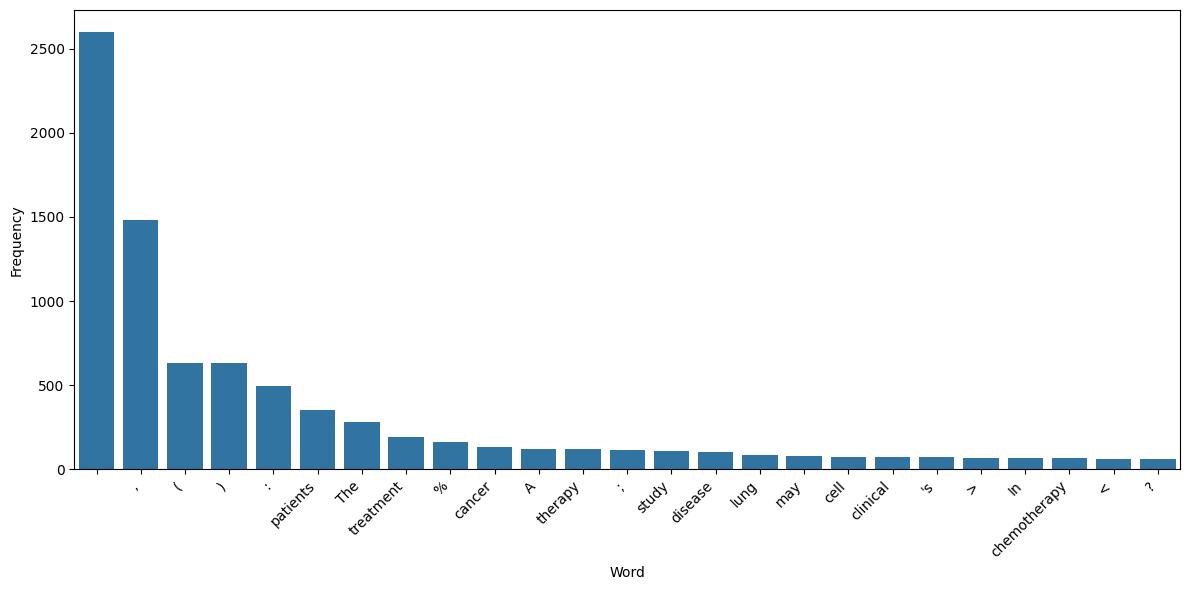

In [15]:
plot_word_frequency(train_sentences,25)

In [16]:
train_sentences_merged[3]

"The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) "

In [17]:
import pandas as pd
import numpy as np
import os
import spacy
from tqdm import tqdm

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [18]:
# loading the spacy model
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

In [19]:
POS_TAG = nlp(train_sentences_merged[15])
for tok in POS_TAG:
  # if tok.pos_=="NOUN" or tok.pos_ == 'PROPN':
    print(tok.text,"---",tok.lemma_,"---",tok.pos_)

All --- all --- DET
patients --- patient --- NOUN
were --- be --- AUX
managed --- manage --- VERB
by --- by --- ADP
an --- an --- DET
intensified --- intensify --- VERB
protocol --- protocol --- NOUN
, --- , --- PUNCT
including --- include --- VERB
stringent --- stringent --- ADJ
glycemic --- glycemic --- ADJ
control --- control --- NOUN


In [20]:
nouns = []
for POS_TAG in tqdm(train_sentences_merged):
    doc = nlp(POS_TAG)
    for tok in doc:
        if tok.pos_=="NOUN" or tok.pos_ == 'PROPN':
            nouns.append(tok.lemma_.lower())

100%|██████████| 2599/2599 [00:16<00:00, 156.59it/s]


In [21]:
pd.Series(nouns).value_counts().head(25)

patient         412
treatment       216
study           167
%               161
cancer          156
cell            146
effect          129
disease         127
therapy         125
group            98
case             91
lung             91
result           87
year             73
gene             72
rate             70
chemotherapy     68
use              68
trial            65
conclusion       61
protein          60
drug             59
child            59
tumor            58
analysis         57
Name: count, dtype: int64

In [37]:
# Create a DataFrame from the lists
df_sent = pd.DataFrame({'Word': train_sentences_merged, 'NER_Tag': train_labels_merged})
df_sent.head()

,Word,NER_Tag
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O ...
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


In [38]:
# Function to check if 'D' or 'T' is in the NER Tag column
def pos_D(sent):
  POS_TAG_list = []
  POS_TAG = nlp(sent)
  for tok in POS_TAG:
    POS_TAG_list.append(tok.pos_)
  return POS_TAG_list

# Apply the function to each row to create a new column 'Dep_TAG_List'
df_sent['POS_TAG_List'] = df_sent['Word'].apply(pos_D)

In [39]:
import spacy
from spacy import displacy
import pandas as pd
nlp = spacy.load("en_core_web_sm")

def dep_D(sent):
  POS_TAG_list = []
  nlp = spacy.load("en_core_web_sm")
  POS_TAG = nlp(sent)
  for tok in POS_TAG:
    POS_TAG_list.append(tok.dep_)
  return POS_TAG_list

# Apply the function to each row to create a new column 'Dep_TAG_List'
df_sent['DEP_TAG_List'] = df_sent['Word'].apply(dep_D)

In [36]:
df_sent.head(10)

,Word,NER_Tag,Dep_TAG_List,POS_TAG_List
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[DET, ADJ, NOUN, X, CCONJ, PRON, NUM, NOUN, AD...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[DET, ADJ, ADJ, NOUN, AUX, NUM, NOUN, PUNCT, N...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O,"[ADJ, NOUN, AUX, DET, ADV, ADJ, NOUN, PUNCT, N...","[, , , , , , , , , , , , , , ]"
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[DET, PUNCT, PUNCT, VERB, PUNCT, ADJ, NOUN, PU...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O,"[NOUN, ADP, NOUN, AUX, DET, ADV, ADJ, NOUN, AD...","[, , , , , , , , , , , , , , , , , , , , , , ]"
5,Cesarean rates at tertiary care hospitals shou...,O O O O O O O O O O O O O O O O O O O O O O O O,"[ADJ, NOUN, ADP, ADJ, NOUN, NOUN, AUX, AUX, VE...","[, , , , , , , , , , , , , , , , , , , , , , , ]"
6,"In the third trimester , the amniotic fluid in...",O O O O O O O O O O O O O O O O O O O,"[ADP, DET, ADJ, NOUN, PUNCT, DET, ADJ, NOUN, N...","[, , , , , , , , , , , , , , , , , , ]"
7,We hypothesize that as temperature increases t...,O O O O O O O O O O O O O O,"[PRON, VERB, SCONJ, ADP, NOUN, NOUN, PRON, AUX...","[, , , , , , , , , , , , , ]"
8,"From June 11 to August 16 , 1993 , during a pe...",O O O O O O O O O O O O O O O O O O O O O O O ...,"[ADP, PROPN, NUM, ADP, PROPN, NUM, PUNCT, NUM,...","[, , , , , , , , , , , , , , , , , , , , , , ,..."
9,The daily high ambient temperature in our urba...,O O O O O O O O O O O O,"[DET, ADJ, ADJ, NOUN, NOUN, ADP, PRON, ADJ, NO...","[, , , , , , , , , , , ]"


In [30]:

# Function to check if 'D' or 'T' is in the NER Tag column
def contains_D_or_T(tags):
    return 'D' in tags.split() or 'T' in tags.split()

# Filter rows
filtered_df = df_sent[df_sent['NER_Tag'].apply(contains_D_or_T)]

In [31]:
filtered_df.head(10)

,Word,NER_Tag,Dep_TAG_List
12,The study population included 84 women with ge...,O O O O O O O D D O O O O O O O O O O O O O O ...,"[DET, NOUN, NOUN, VERB, NUM, NOUN, ADP, ADJ, N..."
15,All patients were managed by an intensified pr...,O O O O O O O O O O O T T,"[DET, NOUN, AUX, VERB, ADP, DET, VERB, NOUN, P..."
18,We conclude that to reduce the rate of macroso...,O O O O O O O O D D D D D D O T T T O O O O O ...,"[PRON, VERB, DET, PART, VERB, DET, NOUN, ADP, ..."
20,Down syndrome ( 12 cases ) and Edward syndrome...,D D O O O O O D D O O O O O O O O D O O O O O ...,"[ADP, NOUN, PUNCT, NUM, NOUN, PUNCT, CCONJ, PR..."
21,Down syndrome fetuses ( 41.7 % ) had prenatall...,D D O O O O O O O O O O O O O O D D O O O O O ...,"[ADP, NOUN, NOUN, PUNCT, NUM, NOUN, PUNCT, AUX..."
22,Trisomy 21 presented with the following featur...,D D O O O O O O O O O O O D O O D D,"[NOUN, NUM, VERB, ADP, DET, VERB, NOUN, PUNCT,..."
23,Signs observed in fetuses with trisomy 13 were...,O O O O O D D O O O O O O O O O O O O O O O D ...,"[NOUN, VERB, ADP, NOUN, ADP, NOUN, NUM, AUX, P..."
25,Severe preeclampsia was defined by standard cr...,O D O O O O O,"[ADJ, NOUN, AUX, VERB, ADP, ADJ, NOUN]"
27,The rate of overall preeclampsia was not signi...,O O O O D O O O O O O O O O O O O O O O O O O ...,"[DET, NOUN, ADP, ADJ, PROPN, AUX, PART, ADV, A..."
28,"In this retrospective , case-controlled study ...",O O O O O O O O O O O D O O O O O O O O O O O ...,"[ADP, DET, ADJ, PUNCT, NOUN, PUNCT, VERB, NOUN..."


In [33]:
from google.colab import files

# Save dataframe to CSV
filtered_df.to_csv('filtered_sent.csv', index=False)

# Download the file
files.download('filtered_sent.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
POS_TAG = nlp(train_sentences_merged[18])
for tok in POS_TAG:
  # if tok.pos_=="NOUN" or tok.pos_ == 'PROPN':
    print(tok.text,"---",tok.lemma_,"---",tok.pos_)

We --- we --- PRON
conclude --- conclude --- VERB
that --- that --- PRON
to --- to --- PART
reduce --- reduce --- VERB
the --- the --- DET
rate --- rate --- NOUN
of --- of --- ADP
macrosomic --- macrosomic --- ADJ
infants --- infant --- NOUN
in --- in --- ADP
gestational --- gestational --- ADJ
diabetes --- diabetes --- NOUN
cases --- case --- NOUN
, --- , --- PUNCT
good --- good --- ADJ
glycemic --- glycemic --- ADJ
control --- control --- NOUN
should --- should --- AUX
be --- be --- AUX
initiated --- initiate --- VERB
before --- before --- ADP
34 --- 34 --- NUM
completed --- complete --- VERB
gestational --- gestational --- ADJ
weeks --- week --- NOUN


In [ ]:
import spacy
from spacy import displacy
import pandas as pd
nlp = spacy.load("en_core_web_sm")
doc = nlp(train_sentences_merged[18])
for tok in doc:
    print(tok.text,tok.dep_, spacy.explain(tok.dep_))

We nsubj nominal subject
conclude ROOT root
that dobj direct object
to aux auxiliary
reduce xcomp open clausal complement
the det determiner
rate dobj direct object
of prep prepositional modifier
macrosomic amod adjectival modifier
infants pobj object of preposition
in prep prepositional modifier
gestational amod adjectival modifier
diabetes compound compound
cases pobj object of preposition
, punct punctuation
good amod adjectival modifier
glycemic amod adjectival modifier
control nsubjpass nominal subject (passive)
should aux auxiliary
be auxpass auxiliary (passive)
initiated conj conjunct
before prep prepositional modifier
34 nsubj nominal subject
completed amod adjectival modifier
gestational amod adjectival modifier
weeks pobj object of preposition


In [ ]:
doc = nlp(train_sentences_merged[12])
displacy.render(doc, style='dep', jupyter=True)


In [42]:
train_sentences_merged[0]

'All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) '

## Defining features for CRF





In [54]:
# Let's define the features to get the feature value for one word.
# f1 = input word is a noun
# f2 = input word is adjective
# f3 = input word has a dependency tag of 'amod'
# f4 = input word has a dependency tag of 'pobj'
# D - Currrent word is a noun and prev word is ADJ
# D - Noun is a pobj (objecct of preposition) and previous word is amod (adjectival modifier)
# D - Since deseases are written as object of preposition, the word usually preceeds with prepositional modifier
# T - Currrent word is a noun and prev word is ADJ
# T - Noun is a pobj (objecct of preposition) and previous word is amod (adjectival modifier)
# T - Since treatments are written as object of preposition, the word usually preceeds with prepositional modifier

def extract_features(sentence):
    doc = nlp(sentence)
    features = []

    for i, token in enumerate(doc):
        token_features = [
            'word.lower=' + token.text.lower(),
            'pos=' + token.pos_,
            'dep=' + token.dep_,
            'is_start=' + str(i == 0),
            'is_end=' + str(i == len(doc) - 1),
            'prev_word=' + ('' if i == 0 else doc[i-1].text.lower()),
            'prev_pos=' + ('' if i == 0 else doc[i-1].pos_),
            'prev_dep=' + ('' if i == 0 else doc[i-1].dep_),
        ]
        features.append(token_features)

    return features




In [55]:
# Write a code to get features for a sentence.
# Example usage
features = extract_features(train_sentences_merged[0])
print(features)

[['word.lower=all', 'pos=DET', 'dep=det', 'is_start=True', 'is_end=False', 'prev_word=', 'prev_pos=', 'prev_dep='], ['word.lower=live', 'pos=ADJ', 'dep=amod', 'is_start=False', 'is_end=False', 'prev_word=all', 'prev_pos=DET', 'prev_dep=det'], ['word.lower=births', 'pos=NOUN', 'dep=npadvmod', 'is_start=False', 'is_end=False', 'prev_word=live', 'prev_pos=ADJ', 'prev_dep=amod'], ['word.lower=>', 'pos=X', 'dep=punct', 'is_start=False', 'is_end=False', 'prev_word=births', 'prev_pos=NOUN', 'prev_dep=npadvmod'], ['word.lower=or', 'pos=CCONJ', 'dep=cc', 'is_start=False', 'is_end=False', 'prev_word=>', 'prev_pos=X', 'prev_dep=punct'], ['word.lower==', 'pos=PRON', 'dep=conj', 'is_start=False', 'is_end=False', 'prev_word=or', 'prev_pos=CCONJ', 'prev_dep=cc'], ['word.lower=23', 'pos=NUM', 'dep=nummod', 'is_start=False', 'is_end=False', 'prev_word==', 'prev_pos=PRON', 'prev_dep=conj'], ['word.lower=weeks', 'pos=NOUN', 'dep=appos', 'is_start=False', 'is_end=False', 'prev_word=23', 'prev_pos=NUM', 'p

In [53]:
def getLabelsInList(labels):
  return labels.split()

## Getting the features

### Write a code/function to get the features for a sentence

In [50]:
# Write a code to get features for a sentence.
# Example usage
features = extract_features(train_sentences_merged[0])
print(features)

[['word.lower=All', 'pos= DET', 'dep=det', 'is_start=', True, 'is_end=', False, 'prev_word=', '', 'prev_pos=', '', 'prev_dep', ''], ['word.lower=live', 'pos= ADJ', 'dep=amod', 'is_start=', False, 'is_end=', False, 'prev_word=', 'All', 'prev_pos=', 'DET', 'prev_dep', 'det'], ['word.lower=births', 'pos= NOUN', 'dep=npadvmod', 'is_start=', False, 'is_end=', False, 'prev_word=', 'live', 'prev_pos=', 'ADJ', 'prev_dep', 'amod'], ['word.lower=>', 'pos= X', 'dep=punct', 'is_start=', False, 'is_end=', False, 'prev_word=', 'births', 'prev_pos=', 'NOUN', 'prev_dep', 'npadvmod'], ['word.lower=or', 'pos= CCONJ', 'dep=cc', 'is_start=', False, 'is_end=', False, 'prev_word=', '>', 'prev_pos=', 'X', 'prev_dep', 'punct'], ['word.lower==', 'pos= PRON', 'dep=conj', 'is_start=', False, 'is_end=', False, 'prev_word=', 'or', 'prev_pos=', 'CCONJ', 'prev_dep', 'cc'], ['word.lower=23', 'pos= NUM', 'dep=nummod', 'is_start=', False, 'is_end=', False, 'prev_word=', '=', 'prev_pos=', 'PRON', 'prev_dep', 'conj'], ['

### Write a code/function to get the labels of a sentence

In [51]:
# Write a code to get the labels for a sentence.
label_list = getLabelsInList(train_labels_merged[0])
print(label_list)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [56]:
X_train = [extract_features(sentence) for sentence in train_sentences_merged]
X_test = [extract_features(sentence) for sentence in test_sentences_merged]


### Define the labels as the target variable for test and the train dataset

In [58]:
Y_train = [getLabelsInList(labels) for labels in train_labels_merged]
Y_test = [getLabelsInList(labels) for labels in test_labels_merged]

In [68]:
print("X_train example:", X_train[2396])
print("Y_train example:", Y_train[2396])
print(len(train_sentences_merged[2396]))
print(len(train_labels_merged[2396]))
print(len(X_train))
print(len(Y_train))

X_train example: [['word.lower=several', 'pos=ADJ', 'dep=amod', 'is_start=True', 'is_end=False', 'prev_word=', 'prev_pos=', 'prev_dep='], ['word.lower=large', 'pos=ADJ', 'dep=amod', 'is_start=False', 'is_end=False', 'prev_word=several', 'prev_pos=ADJ', 'prev_dep=amod'], ['word.lower=-', 'pos=PUNCT', 'dep=punct', 'is_start=False', 'is_end=False', 'prev_word=large', 'prev_pos=ADJ', 'prev_dep=amod'], ['word.lower=scale', 'pos=NOUN', 'dep=compound', 'is_start=False', 'is_end=False', 'prev_word=-', 'prev_pos=PUNCT', 'prev_dep=punct'], ['word.lower=trials', 'pos=NOUN', 'dep=nsubj', 'is_start=False', 'is_end=False', 'prev_word=scale', 'prev_pos=NOUN', 'prev_dep=compound'], ['word.lower=have', 'pos=AUX', 'dep=aux', 'is_start=False', 'is_end=False', 'prev_word=trials', 'prev_pos=NOUN', 'prev_dep=nsubj'], ['word.lower=firmly', 'pos=ADV', 'dep=advmod', 'is_start=False', 'is_end=False', 'prev_word=have', 'prev_pos=AUX', 'prev_dep=aux'], ['word.lower=established', 'pos=VERB', 'dep=ROOT', 'is_start=

In [70]:
print(train_sentences_merged[2397])
print(train_labels_merged[2397])

< TO_SEE > While diastolic left ventricular ( LV ) dysfunction is frequent and associated with cardiovascular complications in end-stage renal disease treated with dialysis , controversial information exists on diastolic LV function after renal transplantation 
O O O O D D D D D D D O O O O O D D O D D D O O T O O O O O O O O O O O 


## Build the CRF Model

In [60]:
# Build the CRF model.

import sklearn_crfsuite

from sklearn_crfsuite import metrics

In [67]:
# Check for length mismatches in training data
for i in range(len(X_train)):
    if len(X_train[i]) != len(Y_train[i]):
        print(f"Mismatch at index {i}: X_train length = {len(X_train[i])}, Y_train length = {len(Y_train[i])}")
        # Investigate the specific instances at these indices to identify the root cause of the mismatch

Mismatch at index 3: X_train length = 42, Y_train length = 38
Mismatch at index 4: X_train length = 23, Y_train length = 22
Mismatch at index 10: X_train length = 26, Y_train length = 22
Mismatch at index 11: X_train length = 19, Y_train length = 17
Mismatch at index 12: X_train length = 33, Y_train length = 31
Mismatch at index 13: X_train length = 23, Y_train length = 22
Mismatch at index 14: X_train length = 23, Y_train length = 22
Mismatch at index 24: X_train length = 20, Y_train length = 16
Mismatch at index 26: X_train length = 19, Y_train length = 15
Mismatch at index 28: X_train length = 34, Y_train length = 30
Mismatch at index 34: X_train length = 12, Y_train length = 10
Mismatch at index 35: X_train length = 12, Y_train length = 10
Mismatch at index 38: X_train length = 17, Y_train length = 13
Mismatch at index 39: X_train length = 58, Y_train length = 52
Mismatch at index 41: X_train length = 43, Y_train length = 41
Mismatch at index 46: X_train length = 37, Y_train length

In [61]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

ValueError: The numbers of items and labels differ: |x| = 42, |y| = 38

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

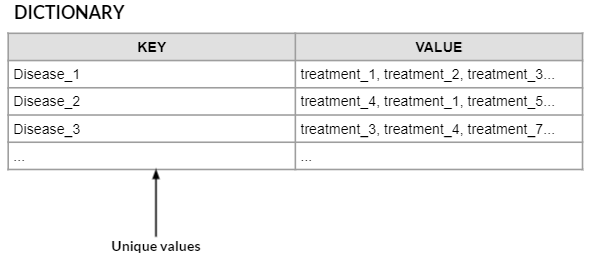

### Predict the treatment for the disease name: 'hereditary retinoblastoma'